In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import time
%matplotlib inline 


In [ ]:
#Load data and format
mf_interaction = pd.read_hdf('18_10_29_mf_interaction_leftDeepCut_resnet50_mf_interaction_male218_10_29shuffle1_150000.h5')
#mf_interaction_female = pd.read_hdf('23_10_18_mf2_interaction1DeepCut_resnet50_mf_interaction_female18_10_23shuffle1_150000.h5')
mf_interaction = mf_interaction.T
#mf_interaction_female = mf_interaction_female.T

In [ ]:
mf_interaction

In [ ]:
#Copy and paste the name of the scorer from the dataframe above (also find out how to get the infor directly from the dataframe..)
scorer = 'DeepCut_resnet50_mf_interaction_male218_10_29shuffle1_150000'


In [ ]:
# the df has a MultiIndex format, this means that you need to use .loc function on the frame with multiple indexes
# you cannot access the data with only the scorer as an index, or some other single index, it will not work
mf_interaction.loc[(scorer, 'male_nose')]

### Clean up and interpolate coords

In [ ]:
def get_x_y_data(data, scorer, bodypart):
    #get x_y_data
    print('bodypart is: ', bodypart)
    bodypart_data = (data.loc[(scorer, bodypart)])
    
    bodypart_data_x = bodypart_data.loc[('x')]
    bodypart_data_y = bodypart_data.loc[('y')]
    
    return bodypart_data_x, bodypart_data_y
    

In [ ]:
def get_x_y_data_cleanup(data, scorer, bodypart, likelihood):
    # sets any value below a particular point to value 0 in x and y, this 0 value can then be used by a later
    #interpolation algorithm
    
    bodypart_data = (data.loc[(scorer, bodypart)])
    
    x_coords = []
    y_coords = []
    
    for index in bodypart_data:
        if bodypart_data.loc['likelihood'][index] > likelihood:
            x_coords.append(bodypart_data.loc['x'][index])
            y_coords.append(bodypart_data.loc['y'][index])
        else:
            x_coords.append(0)
            y_coords.append(0)
            
    return x_coords, y_coords

In [ ]:
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        if value > 0:
            start_value = value
            start_index = index
            break

    for x in range(start_index):
        coords[x] = start_value


In [ ]:

def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
                        print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
    print('function exiting')
    return(coords_list)


In [ ]:
def plot_x_y_coords(x_coords, y_coords, start, end, n_data_plotted, data_index): 
    
    if end == 'end':
        end = len(x_coords)
    
    plt.subplot(3,n_data_plotted,data_index)
    plt.plot(x_coords[start:end])
    plt.subplot(3,n_data_plotted,data_index+n_data_plotted)
    plt.plot(y_coords[start:end])
    plt.subplot(3,n_data_plotted,data_index+ (2*n_data_plotted))
    plt.plot(x_coords[start:end], y_coords[start:end])

##### Look at raw data (see the imperfection due to failures of DLC to consistently predict correctly)

In [ ]:
male_left_ear_x_raw, male_left_ear_y_raw = get_x_y_data(mf_interaction, scorer, 'male_left_ear')
male_right_ear_x_raw, male_right_ear_y_raw = get_x_y_data(mf_interaction, scorer, 'male_right_ear')
male_nose_x_raw, male_nose_y_raw = get_x_y_data(mf_interaction, scorer, 'male_nose')
male_tail_x_raw, male_tail_y_raw = get_x_y_data(mf_interaction, scorer, 'male_tail')

In [ ]:
female_left_ear_x_raw, female_left_ear_y_raw = get_x_y_data(mf_interaction, scorer, 'female_left_ear')
female_right_ear_x_raw, female_right_ear_y_raw = get_x_y_data(mf_interaction, scorer, 'female_right_ear')
female_nose_x_raw, female_nose_y_raw = get_x_y_data(mf_interaction, scorer, 'female_nose')
female_tail_x_raw, female_tail_y_raw = get_x_y_data(mf_interaction, scorer, 'female_tail')

In [ ]:
%matplotlib inline
plt.figure(figsize = (10,10))
#use plotting function to plot the coords and see them combined
plt.title('no interpolaton and no filter', size = 15)
plot_x_y_coords(male_nose_x_raw, male_nose_y_raw, 50, 2000, 1, 1)
plt.tight_layout()

#### Look at data after DLC predicted locations that are < a threshold_confidence are removed and interpolated over, starting by looking at only one bodypart

In [ ]:
# this will set all values where DLC gave a predicted location at less than a specified confidence interval to 0
female_nose_0s_x, female_nose_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_nose', 0.98)

In [ ]:
female_nose_0s_y

In [ ]:
# this will interpolate linearly over all co-ordinates set to 0 in the previous function '0scleanup'
start_value_cleanup(female_nose_0s_x)
start_value_cleanup(female_nose_0s_y)
female_nose_interpolated_x = interp_0_coords(female_nose_0s_x)
female_nose_interpolated_y = interp_0_coords(female_nose_0s_y)

In [ ]:
plt.figure(figsize = (15,10))

#plot raw
plt.title('no interpolaton and no filter', size = 15)
plot_x_y_coords(male_nose_x_raw, male_nose_y_raw, 50, 200, 2, 1)
plt.title('0s -> lfilter', size = 15)
plot_x_y_coords(female_nose_interpolated_x, female_nose_interpolated_y, 50, 1000, 2, 2)
plt.title('0s -> interpolation -> lfilter', size = 15)
plt.tight_layout()

#Q: Are there more suitable filters than linear filter?

#### Now can smooth over the data using linear fileter

In [ ]:
from scipy.signal import lfilter

In [ ]:
n= 20 # the larger n is, the smoother curve will be

nom = [1.0 / n] * n
denom = 1
female_nose_interpolated_lfilt_x = lfilter(nom,denom,female_nose_interpolated_x)
female_nose_interpolated_lfilt_y = lfilter(nom,denom,female_nose_interpolated_y)

#this is data before
female_nose_0s_lfilt_x = lfilter(nom,denom,female_nose_0s_x)
female_nose_0s_lfilt_y = lfilter(nom,denom,female_nose_0s_y)

In [ ]:
%matplotlib inline

#Comparing how good the home-made interpolation + lfilter is, compared to non-interpolated + filter

plt.figure(figsize = (13,8))

#plot unfiltered

#plt.title('no interpolaton and no filter', size = 15)
plot_x_y_coords(male_nose_x_raw, male_nose_y_raw, 50, 1000, 3, 1)
#plt.title('0s -> lfilter', size = 15)
plot_x_y_coords(female_nose_0s_lfilt_x, female_nose_0s_lfilt_y, 50, 1000, 3, 2)
#plt.title('0s -> interpolation -> lfilter', size = 15)
plot_x_y_coords(female_nose_interpolated_lfilt_x, female_nose_interpolated_lfilt_y, 50, 1000, 3, 3)



plt.tight_layout()

### Have determined that data looks best after likeihood cleanup, interpolation, and then a linear filter -> do for all the data

In [ ]:
female_nose_0s_x, female_nose_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_nose', 0.98)
female_tail_0s_x, female_tail_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_tail', 0.98)
female_right_ear_0s_x, female_right_ear_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_right_ear', 0.98)
female_left_ear_0s_x, female_left_ear_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'female_left_ear', 0.98)


In [ ]:
male_nose_0s_x, male_nose_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'male_nose', 0.98)
male_tail_0s_x, male_tail_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'male_tail', 0.98)
male_right_ear_0s_x, male_right_ear_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'male_right_ear', 0.98)
male_left_ear_0s_x, male_left_ear_0s_y = get_x_y_data_cleanup(mf_interaction, scorer, 'male_left_ear', 0.98)

In [ ]:
start_value_cleanup(male_nose_0s_x)
start_value_cleanup(male_nose_0s_y)
male_nose_interpolated_x = interp_0_coords(male_nose_0s_x)
male_nose_interpolated_y = interp_0_coords(male_nose_0s_y)

start_value_cleanup(male_tail_0s_x)
start_value_cleanup(male_tail_0s_y)
male_tail_interpolated_x = interp_0_coords(male_tail_0s_x)
male_tail_interpolated_y = interp_0_coords(male_tail_0s_y)

start_value_cleanup(male_right_ear_0s_x)
start_value_cleanup(male_right_ear_0s_y)
male_right_ear_interpolated_x = interp_0_coords(male_right_ear_0s_x)
male_right_ear_interpolated_y = interp_0_coords(male_right_ear_0s_y)

start_value_cleanup(male_left_ear_0s_x)
start_value_cleanup(male_left_ear_0s_y)
male_left_ear_interpolated_x = interp_0_coords(male_left_ear_0s_x)
male_left_ear_interpolated_y = interp_0_coords(male_left_ear_0s_y)

In [ ]:
start_value_cleanup(female_nose_0s_x)
start_value_cleanup(female_nose_0s_y)
female_nose_interpolated_x = interp_0_coords(female_nose_0s_x)
female_nose_interpolated_y = interp_0_coords(female_nose_0s_y)

start_value_cleanup(female_tail_0s_x)
start_value_cleanup(female_tail_0s_y)
female_tail_interpolated_x = interp_0_coords(female_tail_0s_x)
female_tail_interpolated_y = interp_0_coords(female_tail_0s_y)

start_value_cleanup(female_right_ear_0s_x)
start_value_cleanup(female_right_ear_0s_y)
female_right_ear_interpolated_x = interp_0_coords(female_right_ear_0s_x)
female_right_ear_interpolated_y = interp_0_coords(female_right_ear_0s_y)

start_value_cleanup(female_left_ear_0s_x)
start_value_cleanup(female_left_ear_0s_y)
female_left_ear_interpolated_x = interp_0_coords(female_left_ear_0s_x)
female_left_ear_interpolated_y = interp_0_coords(female_left_ear_0s_y)

In [ ]:
female_nose_interpolated_lfilt_x = lfilter(nom,denom,female_nose_interpolated_x)
female_nose_interpolated_lfilt_y = lfilter(nom,denom,female_nose_interpolated_y)

female_tail_interpolated_lfilt_x = lfilter(nom,denom,female_tail_interpolated_x)
female_tail_interpolated_lfilt_y = lfilter(nom,denom,female_tail_interpolated_y)

female_right_ear_interpolated_lfilt_x = lfilter(nom,denom,female_right_ear_interpolated_x)
female_right_ear_interpolated_lfilt_y = lfilter(nom,denom,female_right_ear_interpolated_y)

female_left_ear_interpolated_lfilt_x = lfilter(nom,denom,female_left_ear_interpolated_x)
female_left_ear_interpolated_lfilt_y = lfilter(nom,denom,female_left_ear_interpolated_y)

In [26]:
male_nose_interpolated_lfilt_x = lfilter(nom,denom,male_nose_interpolated_x)
male_nose_interpolated_lfilt_y = lfilter(nom,denom,male_nose_interpolated_y)

male_tail_interpolated_lfilt_x = lfilter(nom,denom,male_tail_interpolated_x)
male_tail_interpolated_lfilt_y = lfilter(nom,denom,male_tail_interpolated_y)

male_right_ear_interpolated_lfilt_x = lfilter(nom,denom,male_right_ear_interpolated_x)
male_right_ear_interpolated_lfilt_y = lfilter(nom,denom,male_right_ear_interpolated_y)

male_left_ear_interpolated_lfilt_x = lfilter(nom,denom,male_left_ear_interpolated_x)
male_left_ear_interpolated_lfilt_y = lfilter(nom,denom,male_left_ear_interpolated_y)

C:\Users\yult\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


### Animation

In [ ]:
%matplotlib

fig, ax = plt.subplots(figsize=(8,7))

pause = 1/35 # should match fps of camera

for t in range(len(male_nose_interpolated_lfilt_x)):
    if t == 0:
        points1, = ax.plot(male_nose_interpolated_lfilt_x, male_nose_interpolated_lfilt_y, marker='o', linestyle='None', color = 'blue')
        points2, = ax.plot(male_tail_interpolated_lfilt_x, male_tail_interpolated_lfilt_y, marker='o', linestyle='None', color = 'black')
        points3, = ax.plot(male_right_ear_interpolated_lfilt_x, male_right_ear_interpolated_lfilt_y, marker='o', linestyle='None', color = 'cyan')
        points4, = ax.plot(male_left_ear_interpolated_lfilt_x, male_left_ear_interpolated_lfilt_y, marker='o', linestyle='None', color = 'lightblue')
        
        points5, = ax.plot(female_nose_interpolated_lfilt_x, female_nose_interpolated_lfilt_y, marker='o', linestyle='None', color = 'red')
        points6, = ax.plot(female_tail_interpolated_lfilt_x, female_tail_interpolated_lfilt_y, marker='o', linestyle='None', color = 'pink')
        points7, = ax.plot(female_right_ear_interpolated_lfilt_x, female_right_ear_interpolated_lfilt_y, marker='o', linestyle='None', color = 'purple')
        points8, = ax.plot(female_left_ear_interpolated_lfilt_x, female_left_ear_interpolated_lfilt_y, marker='o', linestyle='None', color = 'salmon')        
        
        ax.set_xlim(500, 2000) 
        ax.set_ylim(0, 1000) 
    else:
        x = male_nose_interpolated_lfilt_x[t]
        y =male_nose_interpolated_lfilt_y[t]
        points1.set_data(x, y)
        
        x = male_tail_interpolated_lfilt_x[t]
        y = male_tail_interpolated_lfilt_y[t]
        points2.set_data(x, y)
        
        x = male_right_ear_interpolated_lfilt_x[t]
        y = male_right_ear_interpolated_lfilt_y[t]
        points3.set_data(x, y)
        
        x = male_left_ear_interpolated_lfilt_x[t]
        y = male_left_ear_interpolated_lfilt_y[t]
        points4.set_data(x, y)
        
        
        
        x = female_nose_interpolated_lfilt_x[t]
        y = female_nose_interpolated_lfilt_y[t]
        points5.set_data(x, y)
        
        x = female_tail_interpolated_lfilt_x[t]
        y = female_tail_interpolated_lfilt_y[t]
        points6.set_data(x, y)
        
        x = female_right_ear_interpolated_lfilt_x[t]
        y = female_right_ear_interpolated_lfilt_y[t]
        points7.set_data(x, y)
        
        x = female_left_ear_interpolated_lfilt_x[t]
        y = female_left_ear_interpolated_lfilt_y[t]
        points8.set_data(x, y)
        
    plt.pause(pause)

In [ ]:
male_nose_interpolated_lfilt_x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation


def animate2(i):

    ax1.clear()
    ax1.plot(male_nose_interpolated_lfilt_x[i], male_nose_interpolated_lfilt_x[i])

# ---

#test_data=np.array([[3, 7],[1, 2],[8, 11],[5, -12],[20, 25], [-3, 30], [2,2], [17, 17]])

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

# create animation
animation.FuncAnimation(fig, animate2, frames=range(1, len(male_nose_interpolated_lfilt_x)), interval=1/30, repeat=False)

# start animation
HTML(anim.to_html5_video())

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(500, 2000) 
ax.set_ylim(0, 1000) 

line, = ax.plot([], [], lw=20)

#ax.set_xlim(( 0, 2))
#ax.set_ylim((-2, 2))

#line, = ax.plot([], [], lw=20)


def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.array(male_nose_interpolated_lfilt_x)[i]
    y = np.array(male_nose_interpolated_lfilt_y)[i]
    line.set_data(x, y)
# animation function. This is called sequentially
#    x = np.linspace(0, 2, 1000)
#    y = np.sin(2 * np.pi * (x - 0.01 * i))
#    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=20, blit=True)

HTML(anim.to_html5_video())


In [ ]:
data_x = np.array(mother_earR_x)

In [ ]:
data = np.array([mother_earR_x, mother_earR_y])

In [ ]:
data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create initial data
data = np.array([mother_earR_x, mother_earR_y])

# Create figure and axes
fig = plt.figure()
ax = plt.axes(xlim=(0, 200), ylim=(0, 10))

# Create initial objects
line, = ax.plot([], [], 'r-')
annotation = ax.annotate('A0', xy=(data[0][0], data[1][0]))
annotation.set_animated(True)

# Create the init function that returns the objects
# that will change during the animation process
def init():
    return line, annotation

# Create the update function that returns all the
# objects that have changed
def update(num):
    newData = np.array([[1 + num, 2 + num / 2, 3, 4 - num / 4, 5 + num],
                        [7, 4, 9 + num / 3, 2, 3]])
    line.set_data(newData)
    # This is not working i 1.2.1
    # annotation.set_position((newData[0][0], newData[1][0]))
    annotation.xytext = (newData[0][0], newData[1][0])
    return line, annotation

anim = animation.FuncAnimation(fig, update, frames=25, init_func=init,
                               interval=200, blit=True)
HTML(anim.to_html5_video())

### OUR SHITTY CODE

In [27]:
def zip_xy(x_pos, y_pos):
    
    xy = np.stack((x_pos, y_pos), axis =-1)
    
    return xy

female_nose_xy = zip_xy(female_nose_interpolated_lfilt_x,female_nose_interpolated_lfilt_y)
female_tail_xy = zip_xy(female_tail_interpolated_lfilt_x,female_tail_interpolated_lfilt_y)
female_right_ear_xy = zip_xy(female_right_ear_interpolated_lfilt_x,female_right_ear_interpolated_lfilt_y)
female_left_ear_xy = zip_xy(female_left_ear_interpolated_lfilt_x,female_left_ear_interpolated_lfilt_y)

female_body_midpt_xy = (female_nose_xy + female_tail_xy)/2

male_nose_xy = zip_xy(male_nose_interpolated_lfilt_x,male_nose_interpolated_lfilt_y)
male_tail_xy = zip_xy(male_tail_interpolated_lfilt_x,male_tail_interpolated_lfilt_y)
male_right_ear_xy = zip_xy(male_right_ear_interpolated_lfilt_x,male_right_ear_interpolated_lfilt_y)
male_left_ear_xy = zip_xy(male_left_ear_interpolated_lfilt_x,male_left_ear_interpolated_lfilt_y)

male_body_midpt_xy = (male_nose_xy + male_tail_xy)/2

In [28]:
### for nose-nose/tail/body distances

In [29]:
def find_distance(body_part_1_xy, body_part_2_xy):
    
    vector_btwn_parts = body_part_1_xy - body_part_2_xy
    distanceOverTime = np.linalg.norm(vector_btwn_parts,axis=1)
    #distanceOverTime = np.sqrt(((body_part_1_xy[:,0]-body_part_2_xy[:,0])**2) + ((body_part_1_xy[:,1]-body_part_2_xy[:,1])**2))
    return distanceOverTime

nose_nose_dist = find_distance(male_nose_xy, female_nose_xy)
male_nose_female_tail_dist  = find_distance(male_nose_xy, female_tail_xy)
male_nose_female_body_dist  = find_distance(male_nose_xy, female_body_midpt_xy)

female_nose_male_tail_dist  = find_distance(female_nose_xy, male_tail_xy)
female_nose_male_body_dist  = find_distance(female_nose_xy, male_body_midpt_xy)

In [30]:
def sniffing_threshold(distanceOverTime, threshold=50):
    sniffing_behaviour = []
    
    for distance in distanceOverTime:
        if distance < threshold:
            sniffing_behaviour.append(1)
        else:
            sniffing_behaviour.append(0)
    
    return sniffing_behaviour

In [31]:
mutual_sniffing = sniffing_threshold(nose_nose_dist)

male_anogenital_sniffing = sniffing_threshold(male_nose_female_tail_dist)
male_body_sniffing = sniffing_threshold(male_nose_female_body_dist)

female_anogenital_sniffing = sniffing_threshold(female_nose_male_tail_dist)
female_body_sniffing = sniffing_threshold(female_nose_male_body_dist)

Using matplotlib backend: Qt5Agg


Text(0.5,1,'female anogenital(red)/ body(blue) sniffing')

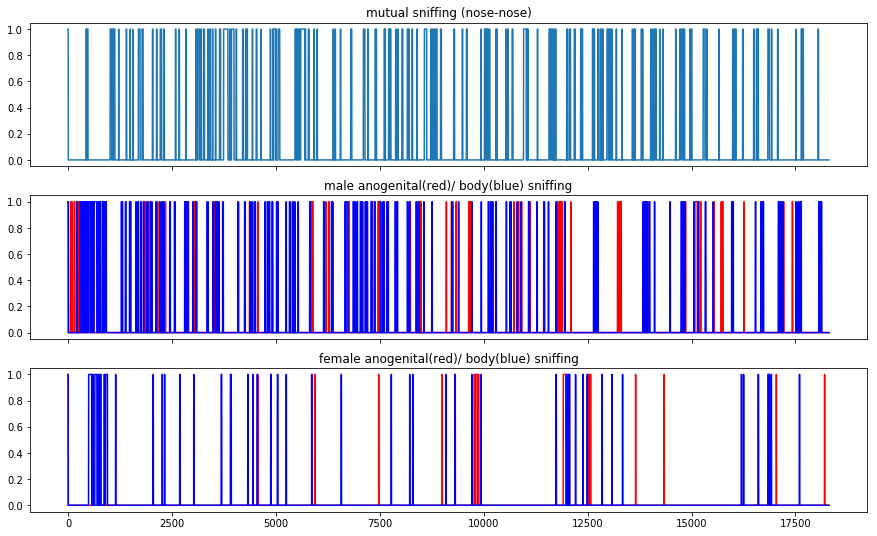

In [32]:
%matplotlib

fig, axes = plt.subplots(nrows=3, sharex = True, figsize=(15,9))

axes[0].plot(mutual_sniffing)
axes[0].set_title("mutual sniffing (nose-nose)")

axes[1].plot(male_anogenital_sniffing, color = 'red')
axes[1].plot(male_body_sniffing, color = 'blue')
axes[1].set_title("male anogenital(red)/ body(blue) sniffing")

axes[2].plot(female_anogenital_sniffing, color = 'red')
axes[2].plot(female_body_sniffing, color = 'blue')
axes[2].set_title("female anogenital(red)/ body(blue) sniffing")

In [33]:
### orienting, male/female "interest"

In [34]:
def target_theta(nose_xy, left_ear_xy, right_ear_xy, target_xy):
    
    mid_pt_btwn_ears_xy = (left_ear_xy+right_ear_xy)/2
    
    head_dir_vector = nose_xy - mid_pt_btwn_ears_xy
      
    ear_mid_pt_to_target_vector =  target_xy - mid_pt_btwn_ears_xy
    
    theta_to_target = []
    
    for t in range(len(head_dir_vector)):
        dot_pdt = np.dot(head_dir_vector[t],ear_mid_pt_to_target_vector[t])
        
        theta = np.arccos(dot_pdt)/np.linalg.norm(head_dir_vector[t])/np.linalg.norm(ear_mid_pt_to_target_vector[t]))
        theta_to_target.append(theta)
        
    return theta_to_target

In [56]:
def orienting_threshold(theta_to_target,threshold = np.pi/100):
    orienting_to_target = []
    
    for theta in theta_to_target:
        if theta < threshold or theta > 2*np.pi - threshold:
            orienting_to_target.append(1)
        else:
            orienting_to_target.append(0)   
            
    return orienting_to_target

In [57]:
def interest(nose_xy, left_ear_xy, right_ear_xy, target_nose_xy, target_tail_xy):
    
    theta_to_target_nose = target_theta(nose_xy, left_ear_xy, right_ear_xy, target_nose_xy)
    theta_to_target_tail = target_theta(nose_xy, left_ear_xy, right_ear_xy, target_tail_xy)
    
    orienting_to_nose = orienting_threshold(theta_to_target_nose)
    orienting_to_tail = orienting_threshold(theta_to_target_tail)
    
    interest = orienting_to_nose + orienting_to_tail
    
    return interest, orienting_to_nose, orienting_to_tail

In [58]:
female_interest,_ ,_ = interest(female_nose_xy, female_left_ear_xy, female_right_ear_xy, male_nose_xy, male_tail_xy)
male_interest, _, _ = interest(male_nose_xy, male_left_ear_xy, male_right_ear_xy, female_nose_xy, female_tail_xy)

Text(0.5,1,'female interest')

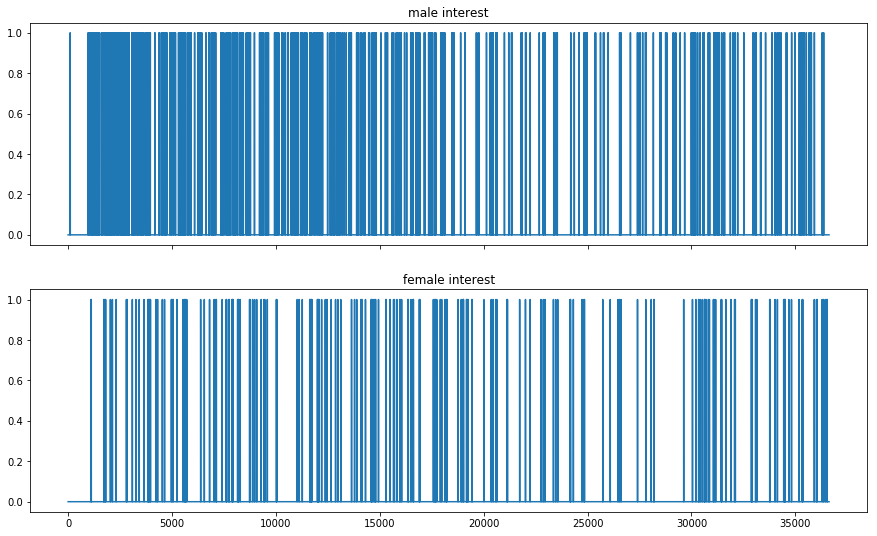

In [59]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, sharex = True, figsize=(15,9))

axes[0].plot(male_interest)
axes[0].set_title("male interest")

axes[1].plot(female_interest)
axes[1].set_title("female interest")

In [86]:
import scipy 

def following(nose_xy, body_midpt_xy,time_bin = 35):
    
    num_bins = int(len(nose_xy)/time_bin)
    
    following_value = np.empty(len(nose_xy))
    
    for i in range(num_bins):
        bin_start = i*time_bin
        bin_end = (i+1)*time_bin
        
        cross_corr = scipy.signal.correlate(nose_xy[bin_start:bin_end,],body_midpt_xy[bin_start:bin_end,],mode='full')
        
        following_value[bin_start:bin_end].fill(np.amax(cross_corr))
        
        
    return following_value       

C:\Users\yult\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\yult\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  in1zpadded[sc] = in1.copy()


58431492.455490775


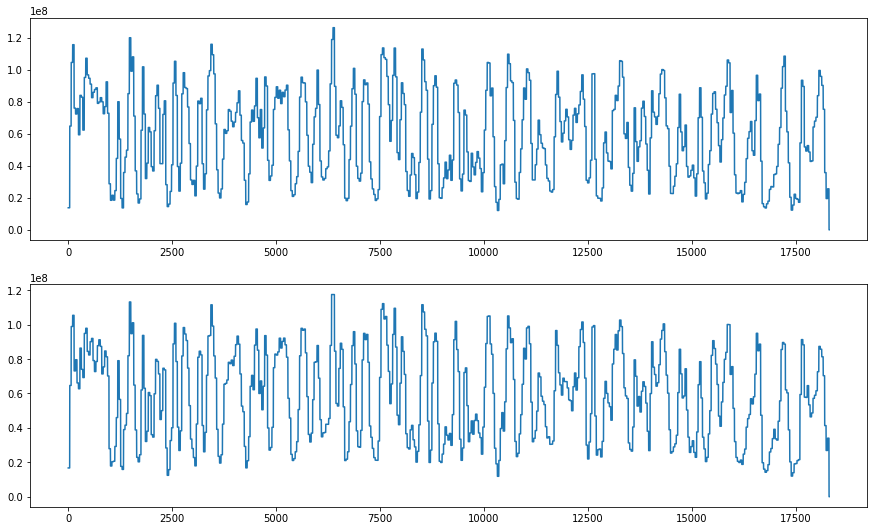

In [98]:
def following_threshold(following_value, threshold=50000000):
    following_behaviour = []
    
    for following in following_value:
        if following < threshold:
            following_behaviour.append(1)
        else:
            following_behaviour.append(0)
    
    return following_behaviour

male_following = following(male_nose_xy,female_body_midpt_xy)
female_following = following(female_nose_xy,male_body_midpt_xy)

thr = following_threshold(test)

%matplotlib inline

fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(15,9))

ax1.plot(male_following)
ax2.plot(female_following)

print(np.mean(test))